# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [122]:
import pandas as pd

In [123]:
data = pd.read_csv('train.csv')

In [124]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [125]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [126]:
train.isna().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [127]:
#Пропуски существуют в keyword и location

In [128]:
test.isna().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [129]:
train.fillna('', inplace=True)
test.fillna('', inplace=True)

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [130]:
#1
len(train['target'].unique())

2

In [131]:
a1 = train['target'].value_counts()[0] / len(train['target'])
a2 = train['target'].value_counts()[1] / len(train['target'])
print(f'распределение 0 и 1 ко всем: {a1} и {a2}')

распределение 0 и 1 ко всем: 0.5674610621129668 и 0.43253893788703324


In [132]:
#2
a = list(zip(train['keyword'].value_counts(), train['keyword']))
b = sorted(a, reverse = True)
b[:10]

[(44, 'bridge%20collapse'),
 (36, 'hail'),
 (35, 'police'),
 (34, 'rioting'),
 (33, 'wounds'),
 (31, 'airplane%20accident'),
 (30, 'wreck'),
 (30, 'wounded'),
 (30, 'mudslide'),
 (30, 'electrocuted')]

In [133]:
c = [i[1] for i in b[:10]]

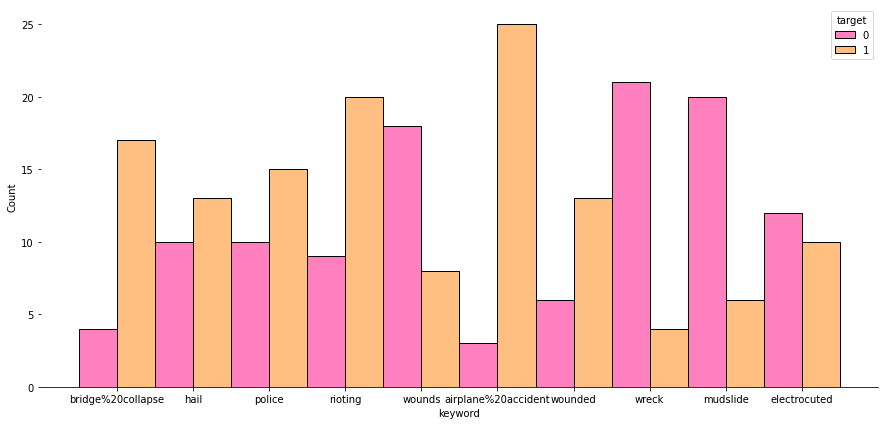

In [134]:
import seaborn as sns
from matplotlib import pyplot as plt

df = train[train['keyword'].isin(c)]
plt.figure(figsize=(15,7))
sns.histplot(x = "keyword", hue = "target", data = df, multiple = "dodge", palette="spring")
sns.despine(left=True)

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [135]:
train.head()

,id,keyword,location,text,target
1186,1707,bridge%20collapse,,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0
4071,5789,hail,"Carol Stream, Illinois",GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...,1
5461,7789,police,Houston,CNN: Tennessee movie theater shooting suspect ...,1
5787,8257,rioting,,Still rioting in a couple of hours left until ...,1
7445,10656,wounds,Lake Highlands,Crack in the path where I wiped out this morni...,0


In [136]:
train['key/loc/text'] = train['keyword'].str.cat(train['location'], sep =" ")
test['key/loc/text'] = test['keyword'].str.cat(test['location'], sep =" ")
train['key/loc/text'] = train['key/loc/text'].str.cat(train['text'], sep =" ")
test['key/loc/text'] = test['key/loc/text'].str.cat(test['text'], sep =" ")

In [137]:
train.drop(['keyword', 'location', 'text', 'id'], axis=1, inplace=True)
test.drop(['keyword', 'location', 'text', 'id'], axis=1, inplace=True)

In [138]:
train.head(3)

,target,key/loc/text
1186,0,bridge%20collapse Ashes 2015: AustraliaÛªs c...
4071,1,"hail Carol Stream, Illinois GREAT MICHIGAN TEC..."
5461,1,police Houston CNN: Tennessee movie theater s...


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [139]:
from sklearn.feature_extraction.text import CountVectorizer

In [140]:
vec = CountVectorizer()
X = vec.fit_transform(train['key/loc/text'], train['target'])

In [141]:
X

<5329x18455 sparse matrix of type '<class 'numpy.int64'>'
	with 86671 stored elements in Compressed Sparse Row format>

In [142]:
# Матрица получилась 5329x18455

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [143]:
#1
def find_num(a, dig):
    numb = 0
    for i in a:
        for j in dig:
            if j in i:
                numb += 1
                break
    return numb

dig = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
print("Слов, в которых есть цифры: ", find_num(vec.vocabulary_.keys(), dig))
print("Слов, в которых есть символы: ", find_num(vec.vocabulary_.keys(), punc))

Слов, в которых есть цифры:  3812
Слов, в которых есть символы:  315


In [144]:
def find_num2(a, dig):
    numb = 0
    for i in a:
        numb += i.count(dig)
    return numb
print("Хэштегов: ", find_num2(vec.vocabulary_.keys(), "#"))
print("Упоминаний: ", find_num2(vec.vocabulary_.keys(), "@"))

Хэштегов:  0
Упоминаний:  0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [145]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer
tw = TweetTokenizer()
train['key/loc/text'].apply(tw.tokenize)
vec2 = CountVectorizer()
X2 = vec2.fit_transform(train['key/loc/text'], train['target'])

In [146]:
print("Слов, в которых есть цифры: ", find_num(vec2.vocabulary_.keys(), dig))
print("Слов, в которых есть символы: ", find_num(vec2.vocabulary_.keys(), punc))
print("Хэштегов: ", find_num2(vec2.vocabulary_.keys(), "#"))
print("Упоминаний: ", find_num2(vec2.vocabulary_.keys(), "@"))

Слов, в которых есть цифры:  3812
Слов, в которых есть символы:  315
Хэштегов:  0
Упоминаний:  0


In [147]:
train['key/loc/text']

1186    bridge%20collapse  Ashes 2015: AustraliaÛªs c...
4071    hail Carol Stream, Illinois GREAT MICHIGAN TEC...
5461    police Houston  CNN: Tennessee movie theater s...
5787    rioting  Still rioting in a couple of hours le...
7445    wounds Lake Highlands Crack in the path where ...
                              ...                        
5226    obliteration Merica! @Eganator2000 There aren'...
5390    panic  just had a panic attack bc I don't have...
860     blood  Omron HEM-712C Automatic Blood Pressure...
7603      Officials say a quarantine is in place at an...
7270    whirlwind Stamford & Cork (& Shropshire) I mov...
Name: key/loc/text, Length: 5329, dtype: object

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [148]:
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


In [159]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/violetta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [160]:
from nltk.corpus import stopwords

In [162]:
def custom_tokenizer(s):
    tokens = []
    tk = TweetTokenizer()
    punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for i in tk.tokenize(s.lower()):
        if i.isalpha():
            tokens.append(i)
        elif i[0] == '#' and i[1:].isalpha():
            tokens.append(i)
        elif not any(map(str.isdigit, i)):
            if i.count(')') + i.count('(') > 0:
                tokens.append(i)
    stemmer = SnowballStemmer('english')
    return [stemmer.stem(i) for i in tokens if i not in nltk.corpus.stopwords.words('english')]

In [207]:
# Пример работы
text = list(train['key/loc/text'])[1]
custom_tokenizer(text)

['hail',
 'carol',
 'stream',
 'illinoi',
 'great',
 'michigan',
 'techniqu',
 'camp',
 'thank',
 '#goblu',
 '#wrestleon']

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [193]:
cnt_vec = CountVectorizer(tokenizer = custom_tokenizer)
train_cnt_vec = cnt_vec.fit_transform(train['key/loc/text'])
test_cnt_vec = cnt_vec.transform(test['key/loc/text'])

In [194]:
from sklearn import *
from sklearn.linear_model import LogisticRegression
x_train = train_cnt_vec
y_train = train['target']
x_test = test_cnt_vec
y_test = test['target']

In [196]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

In [199]:
from sklearn.metrics import f1_score
y_pred = lr.predict(x_test)

print(f1_score(y_test, y_pred))

0.7516129032258064


## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [210]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
train_tfidf_vec = tfidf_vec.fit_transform(train['key/loc/text'])
test_tfidf_vec = tfidf_vec.transform(test['key/loc/text'])
x_tfidf_train = train_tfidf_vec
x_tfidf_test = test_tfidf_vec
lr.fit(x_tfidf_train, y_train)
y_pred = lr.predict(x_tfidf_test)

print(f1_score(y_test, y_pred))

0.7495872317006055


In [211]:
tfidf_vec = TfidfVectorizer(max_df=0.9)
train_tfidf_vec = tfidf_vec.fit_transform(train['key/loc/text'])
test_tfidf_vec = tfidf_vec.transform(test['key/loc/text'])
x_tfidf_train = train_tfidf_vec
x_tfidf_test = test_tfidf_vec
lr.fit(x_tfidf_train, y_train)
y_pred = lr.predict(x_tfidf_test)

print(f1_score(y_test, y_pred))

0.7495872317006055


## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [212]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vec = HashingVectorizer(n_features=5000)
train_hash_vec = hash_vec.fit_transform(train['key/loc/text'])
test_hash_vec = hash_vec.transform(test['key/loc/text'])
x_hash_train = train_hash_vec
x_hash_test = test_hash_vec
lr.fit(x_hash_train, y_train)
y_pred = lr.predict(x_hash_test)

print(f1_score(y_test, y_pred))

0.7253481894150418


In [ ]:
# Лучше всего модель показала себя на данных с собственным векторайзером, а хуже всео с хэшинг векторайзер

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [ ]:
# в задании №8 мера f1 составляет 0.7516129032258064 при написании собственного векторайзера